# 4. Image Convolution

## Table of Contents
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Simple Convolution <a class="anchor" id="simple" ></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

<img src="data/convolution.png" width="70%">

In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__. 

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

In [93]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [94]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [95]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros
    
    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

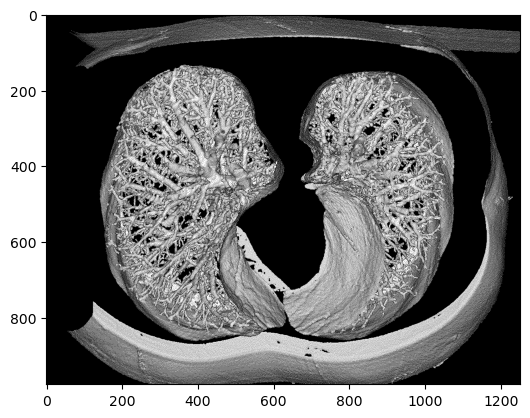

In [96]:
image = Image.open('data/image.jpeg')
image = image.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [97]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

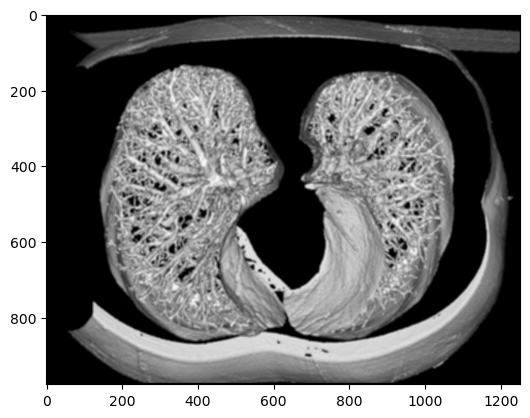

In [98]:
n = 7
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## PyTorch Convolution <a class="anchor" id="pytorch" ></a>

In [99]:
from PIL import Image

img = Image.open('data/image.jpeg')
img.thumbnail((256, 256), Image.Resampling.LANCZOS)

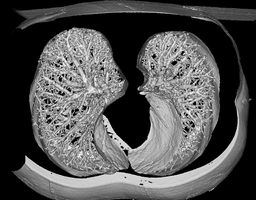

In [100]:
img

In [101]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [102]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [103]:
input = to_tensor(img)
input.shape


torch.Size([1, 200, 256])

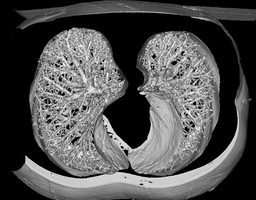

In [104]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [105]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [106]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [107]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 200, 256])

In [108]:
output = conv(input)
output.shape

torch.Size([1, 1, 200, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [109]:
output.shape

torch.Size([1, 1, 200, 256])

We need to remove the first dimension before converting to a PIL object.

In [110]:
output.data.squeeze(dim=0).shape

torch.Size([1, 200, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

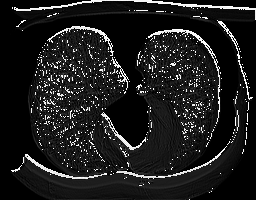

In [111]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

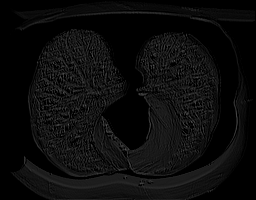

In [112]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [113]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

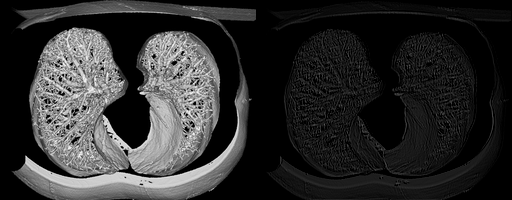

In [114]:
display(input, output)

### Identity

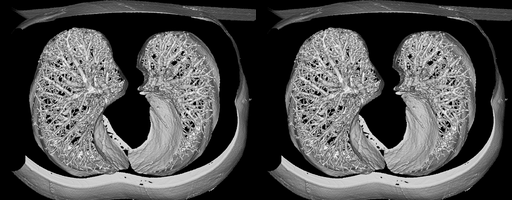

In [115]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


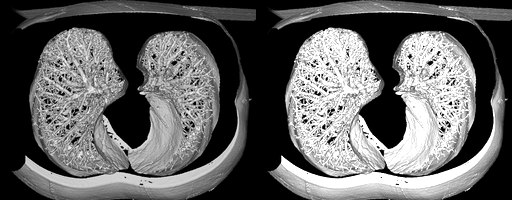

In [116]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


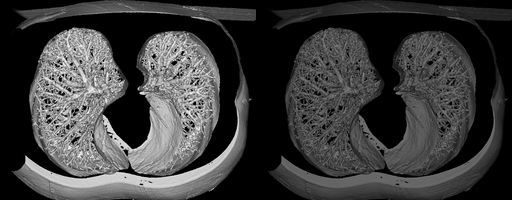

In [117]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


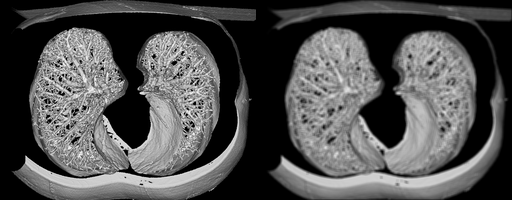

In [118]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


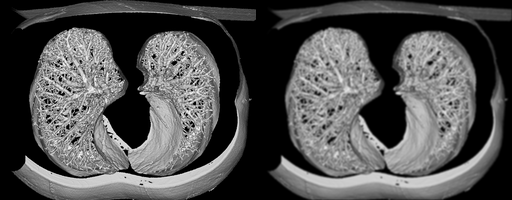

In [119]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


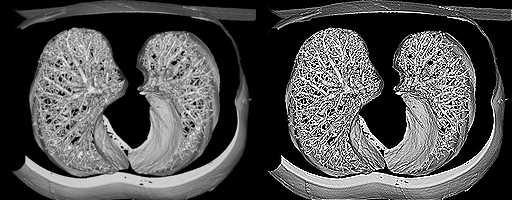

In [120]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


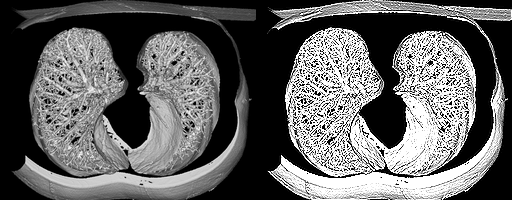

In [121]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


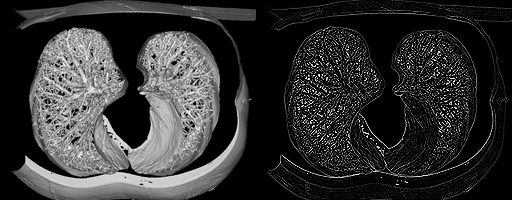

In [122]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

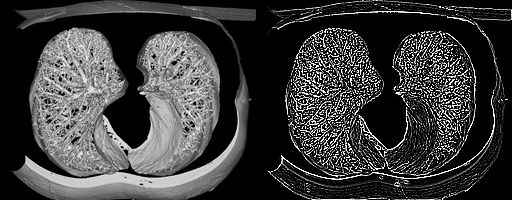

In [123]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

##  Line detectors using Python code: Prewitt, Sobel and Laplacian

In [ ]:
from scipy.ndimage import convolve

def load_image(path):
    image = Image.open(path).convert('L')
    return np.array(image) / 255.0 

image_path = 'data/image.jpeg'
image = load_image(image_path)

def apply_filter(image, kernel):
    return convolve(image, kernel)

# Prewitt kernels
prewitt_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
prewitt_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

# Sobel kernels
sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Laplacian kernel
laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

prewitt_result = apply_filter(image, prewitt_x) + apply_filter(image, prewitt_y)
sobel_result = apply_filter(image, sobel_x) + apply_filter(image, sobel_y)
laplacian_result = apply_filter(image, laplacian)

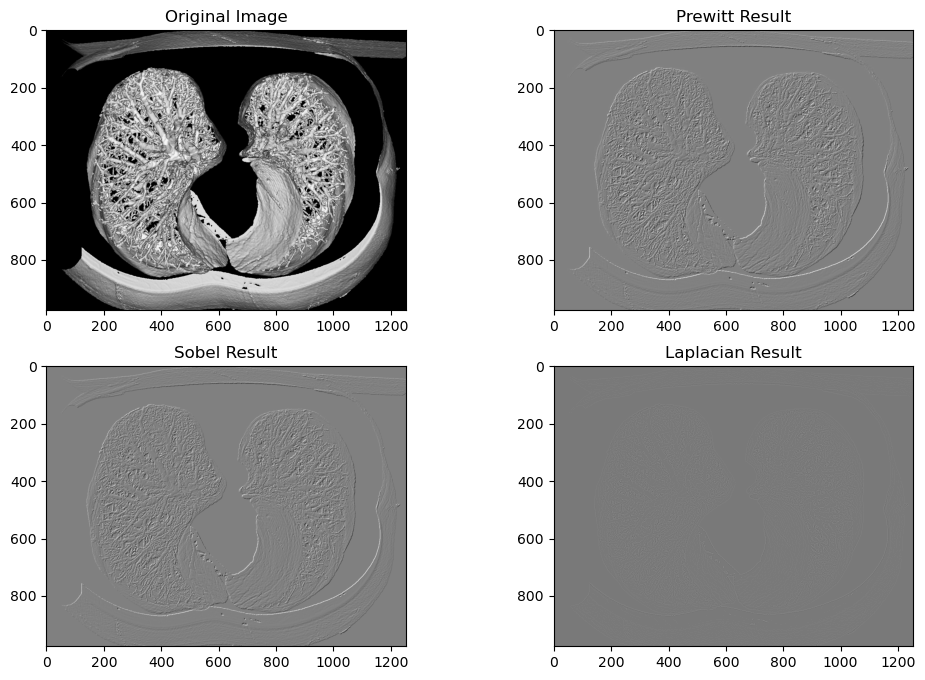

In [131]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Prewitt Result")
plt.imshow(prewitt_result, cmap='gray')

plt.subplot(2, 2, 3)
plt.title("Sobel Result")
plt.imshow(sobel_result, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("Laplacian Result")
plt.imshow(laplacian_result, cmap='gray')

plt.show()

Algorithmic Complexity:

	•	Prewitt and Sobel: O(M * N) with two convolutions (horizontal + vertical).

	•	Laplacian: O(M * N) with a single convolution.

Most efficient: Laplacian is faster due to only one convolution.

## Enhance image

In [ ]:
def enhance_image(image, edges, alpha=1.5):
    enhanced = image + alpha * edges
    return np.clip(enhanced, 0, 1) 

edges = apply_filter(image, sobel_x) + apply_filter(image, sobel_y)
enhanced_image = enhance_image(image, edges)

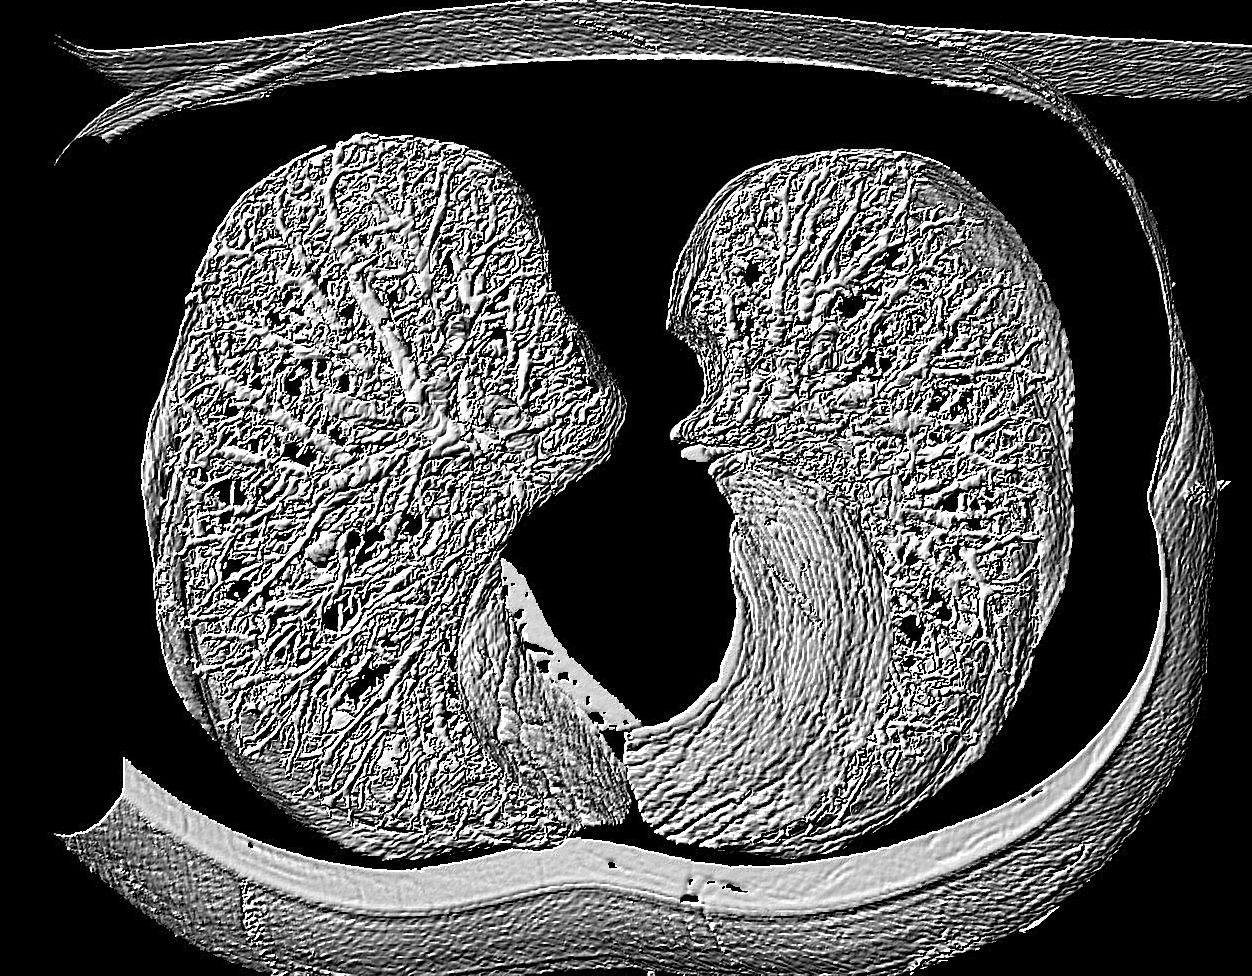

In [133]:
to_pil(enhanced_image)

In [ ]:
smoothed_image = convolve(image, np.ones((3, 3)) / 9)

edges = apply_filter(smoothed_image, prewitt_x) + apply_filter(smoothed_image, prewitt_y)

enhanced_medical_image = enhance_image(smoothed_image, edges, alpha=1.2)

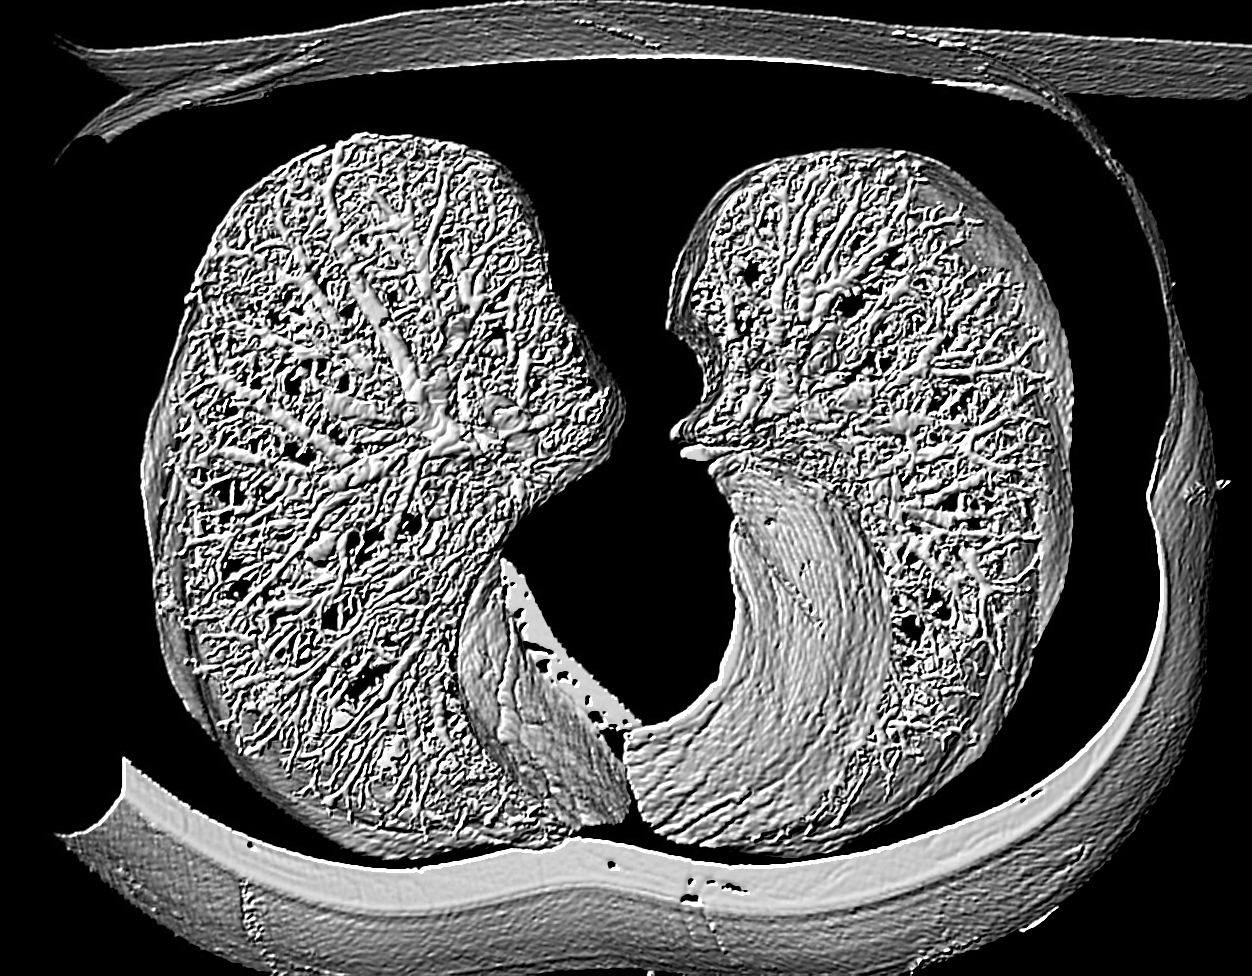

In [136]:
to_pil(enhanced_medical_image)

	1.	Smoothing reduces noise in the medical image.

	2.	Edge detection identifies critical structures (e.g., edges of organs).
	
	3.	Enhancement amplifies these structures for better visual analysis, as described in Gonzalez’s Figure 3.43.

	1.	Gonzalez, R. C., & Woods, R. E. (2018). Digital Image Processing (4th ed.). Pearson.
	2.	Python Software Foundation. (2025). Python Language Reference, version 3.10. Retrieved from https://www.python.org
	3.	Van der Walt, S., Colbert, S. C., & Varoquaux, G. (2011). The NumPy array: A structure for efficient numerical computation. Computing in Science & Engineering, 13(2), 22-30. https://doi.org/10.1109/MCSE.2011.37
	4.	Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95. https://doi.org/10.1109/MCSE.2007.55
	5.	Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., … & Duchesnay, É. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825–2830.
	6.	Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., … & Chintala, S. (2019). PyTorch: An imperative style, high-performance deep learning library. Advances in Neural Information Processing Systems, 32, 8026–8037.